In [1]:
!pip install -q transformers

     |████████████████████████████████| 2.6 MB 8.6 MB/s 
     |████████████████████████████████| 636 kB 44.0 MB/s 
     |████████████████████████████████| 895 kB 40.8 MB/s 
     |████████████████████████████████| 3.3 MB 47.2 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%matplotlib inline
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import re
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler
import transformers
from transformers import RobertaTokenizer, BertTokenizer, RobertaModel, BertModel, AdamW# get_linear_schedule_with_warmup
from transformers import get_linear_schedule_with_warmup
import time

!cp drive/MyDrive/Colab\ Notebooks/MSc-Individual-Project/utils.py .
from utils import *
!cp drive/MyDrive/Colab\ Notebooks/MSc-Individual-Project/Custom_Dataset_Class.py .
from Custom_Dataset_Class import CustomDataset
#from Bert_Classification import Bert_Classification_Model
#from RoBERT import RoBERT_Model

#from BERT_Hierarchical import BERT_Hierarchical_Model
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelBinarizer

In [4]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [5]:
#change to where you store mimic3 data
MIMIC_3_DIR = '/content/drive/MyDrive/Colab Notebooks/MSc-Individual-Project/datasets'

train_df = pd.read_csv('%s/train_50.csv' % MIMIC_3_DIR)
#eval_df = pd.read_csv('%s/dev_50.csv' % MIMIC_3_DIR)
test_df = pd.read_csv('%s/test_50.csv' % MIMIC_3_DIR)

train_df.head()

,SUBJECT_ID,HADM_ID,TEXT,LABELS,length
0,4108,117347,admit pt was admitted from a location un at pt...,272.0,304
1,24464,145442,admission date discharge date date of birth se...,401.9,337
2,13329,103551,unit no numeric identifier admission date disc...,530.81;403.91;414.01;305.1;272.0,345
3,22005,126862,unit no numeric identifier admission date disc...,285.1,347
4,26993,194796,admission date discharge date date of birth se...,272.4;250.00;V45.81;414.01;401.9,367


In [6]:
# split labels by ";", then convert to list
def split_lab (x):
    #print(x)
    return x.split(";")

train_df['LABELS'] = train_df['LABELS'].apply(split_lab)
train_df['TEXT'] = train_df['TEXT'].apply(split_lab)

train_df.head()

,SUBJECT_ID,HADM_ID,TEXT,LABELS,length
0,4108,117347,[admit pt was admitted from a location un at p...,[272.0],304
1,24464,145442,[admission date discharge date date of birth s...,[401.9],337
2,13329,103551,[unit no numeric identifier admission date dis...,"[530.81, 403.91, 414.01, 305.1, 272.0]",345
3,22005,126862,[unit no numeric identifier admission date dis...,[285.1],347
4,26993,194796,[admission date discharge date date of birth s...,"[272.4, 250.00, V45.81, 414.01, 401.9]",367


In [7]:
#check top 50 code
top_50 = pd.read_csv('%s/TOP_50_CODES.csv' % MIMIC_3_DIR)

top_50.head().values

array([['428.0'],
       ['427.31'],
       ['414.01'],
       ['584.9'],
       ['250.00']], dtype=object)

In [8]:
#load multi label binarizer for one-hot encoding
mlb = MultiLabelBinarizer(sparse_output=True)

#labels_onehot = mlb.fit_transform(train_df.pop('LABELS'))
#labels_onehot[0][1]

In [9]:
#change label to one-hot encoding per code
train_df = train_df.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(train_df.pop('LABELS')),
                index=train_df.index,
                columns=mlb.classes_))

train_df.head()

,SUBJECT_ID,HADM_ID,TEXT,length,038.9,244.9,250.00,272.0,272.4,276.0,276.1,276.2,285.1,285.9,287.5,305.1,311,327.23,401.9,403.90,403.91,410.71,412,414.01,424.0,424.1,427.31,427.89,428.0,486,493.90,496,507.0,511.9,518.0,518.81,530.81,584.5,584.9,585.9,599.0,774.2,785.52,995.92,997.1,V05.3,V15.82,V29.0,V30.00,V30.01,V45.81,V45.82,V58.61,V58.67
0,4108,117347,[admit pt was admitted from a location un at p...,304,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,24464,145442,[admission date discharge date date of birth s...,337,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,13329,103551,[unit no numeric identifier admission date dis...,345,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,22005,126862,[unit no numeric identifier admission date dis...,347,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,26993,194796,[admission date discharge date date of birth s...,367,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [10]:
# Convert columns to list of one hot encoding
icd_classes_50 = mlb.classes_

train_df['labels'] = train_df[icd_classes_50].values.tolist()
#train_df.sort_values(['length'], ascending=False, inplace=True)
train_df.head()


,SUBJECT_ID,HADM_ID,TEXT,length,038.9,244.9,250.00,272.0,272.4,276.0,276.1,276.2,285.1,285.9,287.5,305.1,311,327.23,401.9,403.90,403.91,410.71,412,414.01,424.0,424.1,427.31,427.89,428.0,486,493.90,496,507.0,511.9,518.0,518.81,530.81,584.5,584.9,585.9,599.0,774.2,785.52,995.92,997.1,V05.3,V15.82,V29.0,V30.00,V30.01,V45.81,V45.82,V58.61,V58.67,labels
0,4108,117347,[admit pt was admitted from a location un at p...,304,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,24464,145442,[admission date discharge date date of birth s...,337,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
2,13329,103551,[unit no numeric identifier admission date dis...,345,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
3,22005,126862,[unit no numeric identifier admission date dis...,347,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
4,26993,194796,[admission date discharge date date of birth s...,367,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."


In [11]:
#convert into 2 columns dataframe
train_df = pd.DataFrame(train_df, columns=['TEXT', 'labels'])
train_df.columns=['text', 'labels']
train_df.head()

,text,labels
0,[admit pt was admitted from a location un at p...,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,[admission date discharge date date of birth s...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
2,[unit no numeric identifier admission date dis...,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
3,[unit no numeric identifier admission date dis...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
4,[admission date discharge date date of birth s...,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."


In [12]:
#same as train data preparation, but for evaluation
#eval_df = pd.read_csv('%s/dev_50.csv' % MIMIC_3_DIR)

#eval_df['LABELS'] = eval_df['LABELS'].apply(split_lab)

#eval_df = eval_df.join(
#            pd.DataFrame.sparse.from_spmatrix(
#                mlb.fit_transform(eval_df.pop('LABELS')),
#                index=eval_df.index,
#                columns=icd_classes_50))

#eval_df['labels'] = eval_df[icd_classes_50].values.tolist()
#eval_df = pd.DataFrame(eval_df, columns=['TEXT', 'labels'])
#eval_df.columns=['text', 'labels']

#print(len(eval_df.labels[0]))
#eval_df.describe

In [13]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model.

class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        '''
            Load Pretrained model here
            Use return_dict=False for compatibility for 4.x

        '''
        self.l1 = transformers.AutoModel.from_pretrained("bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12", return_dict=False)
        #self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased', return_dict=False)


        self.l2 = torch.nn.Dropout(0.3)

        '''
            Changed Linear Output layer to 50 based on the class
        '''
        self.l3 = torch.nn.Linear(768, 50)

    def forward(self, ids, mask, token_type_ids):
#        print("ids: ", ids.size(), "mask: ", mask.size(), "token type ids: ", token_type_ids.size())
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

model = BERTClass()
model.to(device)

Some weights of the model checkpoint at bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    

In [14]:
EPOCH=10
validation_split = .2
shuffle_dataset = True
random_seed= 42
MIN_LEN=249
MAX_LEN = 100000
CHUNK_LEN=512


print('Loading BERT tokenizer...')
bert_tokenizer = BertTokenizer.from_pretrained('bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12', do_lower_case=True)

dataset=CustomDataset(
    tokenizer=bert_tokenizer,
    min_len=MIN_LEN,
    max_len=MAX_LEN,
    chunk_len=CHUNK_LEN,
    data=train_df)

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]


#print(dataset[train_indices[0]])




Loading BERT tokenizer...


In [15]:

lr=3e-5#1e-3

model=BERTClass().to(device)
optimizer=AdamW(model.parameters(), lr=lr)
#scheduler = get_linear_schedule_with_warmup(optimizer,
                                        #num_warmup_steps = 0,
                                        #num_training_steps = num_training_steps)
val_losses=[]
batches_losses=[]
val_acc=[]
for epoch in range(EPOCH):
    t0 = time.time()
    idx = 0
    batches_losses_sum = 0
    print(f"\n=============== EPOCH {epoch+1} / {EPOCH} ===============\n")

    batches_losses_tmp=train_loop_fun1(dataset, train_indices, model, optimizer, device)
    epoch_loss=np.mean(batches_losses_tmp)
    print(f"\n*** avg_loss : {epoch_loss:.2f}, time : ~{(time.time()-t0)//60} min ({time.time()-t0:.2f} sec) ***\n")
    t1=time.time()
    output, target, val_losses_tmp=eval_loop_fun1(dataset, val_indices, model, device)
    print(f"==> evaluation : avg_loss = {np.mean(val_losses_tmp):.2f}, time : {time.time()-t1:.2f} sec\n")
    tmp_evaluate=evaluate(target.reshape(-1), output)
    print(f"=====>\t{tmp_evaluate}")
    val_acc.append(tmp_evaluate['accuracy'])
    val_losses.append(val_losses_tmp)
    batches_losses.append(batches_losses_tmp)
#    torch.save(model, f"model1/model_epoch{epoch+1}.pt")    

Some weights of the model checkpoint at bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Truncation was not explicitly activated but `max_length` is provided a specific value, p


=============== EPOCH 1 / 10 ===============

___ batch index = 0 / 6249 (0.00%), loss = 0.7033, time = 0.29 secondes ___
___ batch index = 250 / 6249 (4.00%), loss = 0.1861, time = 54.21 secondes ___
___ batch index = 500 / 6249 (8.00%), loss = 0.1788, time = 71.51 secondes ___
___ batch index = 750 / 6249 (12.00%), loss = 0.2611, time = 78.33 secondes ___
___ batch index = 1000 / 6249 (16.00%), loss = 0.3073, time = 88.83 secondes ___
___ batch index = 1250 / 6249 (20.00%), loss = 0.2072, time = 95.99 secondes ___
___ batch index = 1500 / 6249 (24.00%), loss = 0.2567, time = 99.98 secondes ___
___ batch index = 1750 / 6249 (28.00%), loss = 0.3240, time = 108.34 secondes ___
___ batch index = 2000 / 6249 (32.01%), loss = 0.2450, time = 117.34 secondes ___
___ batch index = 2250 / 6249 (36.01%), loss = 0.2260, time = 121.18 secondes ___
___ batch index = 2500 / 6249 (40.01%), loss = 0.2995, time = 133.90 secondes ___
___ batch index = 2750 / 6249 (44.01%), loss = 0.2806, time = 150.07

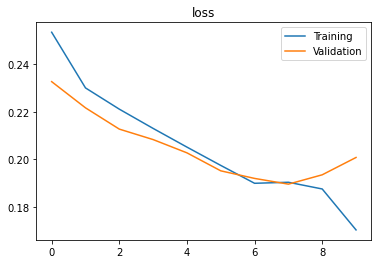

In [16]:
pd.DataFrame(np.array([[np.mean(x) for x in batches_losses], [np.mean(x) for x in val_losses]]).T,
                   columns=['Training', 'Validation']).plot(title="loss")

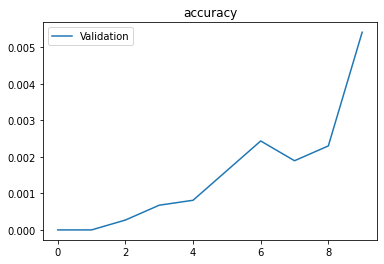

In [17]:
pd.DataFrame(np.array(val_acc).T,
                   columns=['Validation']).plot(title="accuracy")